<a href="https://colab.research.google.com/github/javierFerreroM/NLP_Project/blob/main/NLP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clasificación multilabel de los sentimientos de los tweets

##Introducción al problema

Se trata de un problema de clasificación multietiqueta en el que tenéis que etiquetar un conjunto de tweets de acuerdo a 11 sentimientos ('anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust').
Disponéis de un conjunto de 3561 tweets etiquetas para entrenar y validar el modelo o modelos necesarios, en el archivo 'sem_eval_train_es.csv'.

Cada alumno tiene que validar sus modelos sobre el conjunto ciego de test con el nombre 'sem_eval_test_blank_es.csv'. Cada Tweet tiene un ID (primera columna) que tenéis que mantener en vuestra solución. Debéis aplicar vuestro modelo entrenado a este conjunto y guardarlo en un archivo CSV de nombre 'soluciones_nombre_apellido1_apellido2.csv'. El archivo CSV a entregar debe tener esta estructura de Pandas:

<class 'pandas.core.frame.DataFrame'>  
RangeIndex: 679 entries, 0 to 678  
Data columns (total 12 columns):  

| #  | Column       |  Non-Null Count  | Dtype |  
|--- | ------       |  --------------  | ----- |  
 0   | ID            | 679 non-null    | object|
 1   | anger         | 679 non-null    | bool  |
 2   | anticipation  | 679 non-null    | bool  |
 3   | disgust       | 679 non-null    | bool  |
 4   | fear          | 679 non-null    | bool  |
 5   | joy           | 679 non-null    | bool  |
 6   | love          | 679 non-null    | bool  |
 7   | optimism      | 679 non-null    | bool  |
 8   | pessimism     | 679 non-null    | bool  |
 9   | sadness       | 679 non-null    | bool  |
 10  | surprise      | 679 non-null    | bool  |
 11  | trust         | 679 non-null    | bool  |
dtypes: bool(11), object(1)
Si el archivo no tiene exactamente esa estructura no se podrá evaluar.

Entrega:

Cada alumno deberá entregar a través de esta tarea habilitada en AV el archivo CSV de las predicciones en el conjunto ciego de test y todo el código en Python utilizado tanto para el entrenamiento de los modelos como la inferencia en el conjunto ciego de test. El código Python se entregará como Notebook de Jupyter.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 11.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import re
from unidecode import unidecode
from keras.preprocessing.text import Tokenizer
import nltk 
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf
import copy

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_selection import chi2
# from IPython.display import display
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/NLP/sem_eval_train_es.csv')
print("Training Set:"% train.columns, train.shape, len(train))
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/NLP/sem_eval_test_blank_es.csv')
print("Test Set:"% test.columns, test.shape, len(test))

Training Set: (3561, 13) 3561
Test Set: (679, 2) 679


Es siempre una buena idea limpiar los datos obtenidos. Debemos eliminar signos de puntuación para evitar introducir ruido en el entrenamiento, dado que símbolos de puntuación tales como @, #, !, etc.

Para ello, la biblioteca de python re nos va a permitir buscar expresiones regulares, para eliminar mayúsculas, etc

In [ ]:
train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [ ]:
train.info

<bound method DataFrame.info of                  ID                                              Tweet  anger  \
0     2018-Es-01643  @aliciaenp Ajajjaa somos del clan twitteras pe...  False   
1     2018-Es-05142  @AwadaNai la mala suerte del gato fichame la c...  False   
2     2018-Es-05379  @audiomano A mí tampoco me agrado mucho eso. E...   True   
3     2018-Es-00208  Para llevar a los bebes de un lugar a otro deb...  False   
4     2018-Es-01385  @DalasReview me encanta la terrible hipocresia...   True   
...             ...                                                ...    ...   
3556  2018-Es-06340  Ahorita quisiera que mi preocupación más grand...  False   
3557  2018-Es-00439  El mayor criminal del país diciéndole “delincu...   True   
3558  2018-Es-04919  Mi prima de 4 años se ha enfadado conmigo porq...   True   
3559  2018-Es-02703                      @lennycia Jajaja...  Ya seee   False   
3560  2018-Es-02680  Quiero abrazar. Quiero querer. Me hace falta e...  False

##Prepare the dataset

###Clean the dataset

In [ ]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower() # pasar todo a minúsculas
    df[text_field] = df[text_field].apply(unidecode) # Eliminar los acentos y símbolos sobre las letras
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  # Eliminar caracteres extraños
    return df
test_clean = clean_text(test, "Tweet")
train_clean = clean_text(train, "Tweet")

In [ ]:
train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,ajajjaa somos del clan twitteras perdidas pa ...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,la mala suerte del gato fichame la cara de he...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,a mi tampoco me agrado mucho eso especialment...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,me encanta la terrible hipocresia y doble mor...,True,False,True,False,False,False,False,False,False,False,False


In [ ]:
# Check for null values
np.sum(train_clean.isnull().any(axis=1))

0

###Tokenize the text

In [ ]:
# Tokenizer: Split sentences into words
# The Embedding layer expects the words to be in numeric form.
nltk.download('punkt')
train_clean['tokenized_sents'] = train_clean.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)
test_clean['tokenized_sents'] = test_clean.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_clean['tokenized_sents']

0       [ajajjaa, somos, del, clan, twitteras, perdida...
1       [la, mala, suerte, del, gato, fichame, la, car...
2       [a, mi, tampoco, me, agrado, mucho, eso, espec...
3       [para, llevar, a, los, bebes, de, un, lugar, a...
4       [me, encanta, la, terrible, hipocresia, y, dob...
                              ...                        
3556    [ahorita, quisiera, que, mi, preocupacion, mas...
3557    [el, mayor, criminal, del, pais, diciendole, d...
3558    [mi, prima, de, 4, anos, se, ha, enfadado, con...
3559                                   [jajaja, ya, seee]
3560    [quiero, abrazar, quiero, querer, me, hace, fa...
Name: tokenized_sents, Length: 3561, dtype: object

In [ ]:
test_clean['tokenized_sents']

0      [no, me, pienso, perder, la, pelea, de, mcgreg...
1      [yo, preocupada, pensando, que, mi, papa, ya, ...
2      [pucha, ya, no, me, sirven, todos, los, carros...
3      [si, estar, contigo, es, un, delito, hago, cie...
4      [perfect, y, de, una, mansa, ni, que, terrible...
                             ...                        
674    [peligro, al, volante, tec, los, santos, memes...
675    [vamos, a, ver, q, sucedio, en, mi, barrio, en...
676    [felicidades, fer, que, esta, pasando, al, agu...
677    [lamento, mi, confusion, de, rama, legislativa...
678    [mi, sobrina, vio, la, foto, que, esta, en, la...
Name: tokenized_sents, Length: 679, dtype: object

###Check the configuration of the dataset

{'anger': 1155, 'anticipation': 415, 'disgust': 521, 'fear': 373, 'joy': 1087, 'love': 261, 'optimism': 378, 'pessimism': 578, 'sadness': 845, 'surprise': 169, 'trust': 175, 'tokenized_sents': 0}


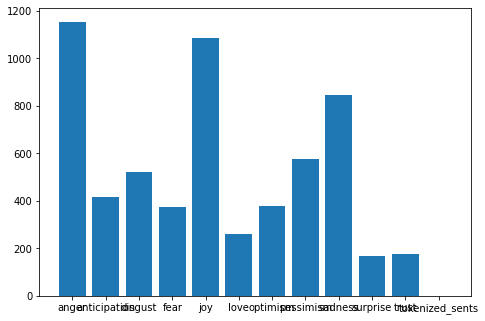

Count of columns in the data is:   14
Count of rows in the data is:   3561


In [ ]:
#Check if the classes are imbalanced
count = {}
for i in train_clean.columns:
  if i not in ['ID', 'Tweet']:
    count[i] = len(train_clean[train_clean[i]==True])
print(count)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(count.keys(),count.values())
plt.show()
# Number of rows and columns
print('Count of columns in the data is:  ', len(train_clean.columns))
print('Count of rows in the data is:  ', len(train_clean))

In [ ]:
train_clean.head(10)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,tokenized_sents
0,2018-Es-01643,ajajjaa somos del clan twitteras perdidas pa ...,False,False,False,False,True,False,False,False,False,False,False,"[ajajjaa, somos, del, clan, twitteras, perdida..."
1,2018-Es-05142,la mala suerte del gato fichame la cara de he...,False,False,False,True,False,False,False,True,False,False,False,"[la, mala, suerte, del, gato, fichame, la, car..."
2,2018-Es-05379,a mi tampoco me agrado mucho eso especialment...,True,False,False,False,False,False,False,False,False,False,False,"[a, mi, tampoco, me, agrado, mucho, eso, espec..."
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False,"[para, llevar, a, los, bebes, de, un, lugar, a..."
4,2018-Es-01385,me encanta la terrible hipocresia y doble mor...,True,False,True,False,False,False,False,False,False,False,False,"[me, encanta, la, terrible, hipocresia, y, dob..."
5,2018-Es-00089,en venezuela el trafico aereo esta tan peligro...,False,True,False,True,False,False,False,True,False,False,False,"[en, venezuela, el, trafico, aereo, esta, tan,..."
6,2018-Es-05189,me voy a morir sin saber por que y y me die...,False,False,False,True,False,False,False,False,True,False,False,"[me, voy, a, morir, sin, saber, por, que, y, y..."
7,2018-Es-02108,terrible esto,True,False,True,False,False,False,False,False,True,False,False,"[terrible, esto]"
8,2018-Es-00795,para tristeza y felicidad ed sheeran al rescate,False,False,False,False,True,False,False,False,True,False,False,"[para, tristeza, y, felicidad, ed, sheeran, al..."
9,2018-Es-02243,con razon mi vieja se fue rapido a santa fe si...,False,False,False,False,False,False,False,True,False,False,False,"[con, razon, mi, vieja, se, fue, rapido, a, sa..."


###Translate words into their numerical values

In [ ]:
# Translate the words into their numerical values for train
all_words = []
embedded_sentences = []

for tweet in train_clean['tokenized_sents']:
  for word in tweet:
    all_words.append(word)

unique_words = set(all_words)
print(len(unique_words))

embedded_sentences = [one_hot(tweet, len(unique_words)) for tweet in train_clean['Tweet']]
print(embedded_sentences)

8726
[[7036, 5668, 1389, 7039, 606, 7764, 5167, 8271, 7991], [5474, 1694, 3164, 1389, 8178, 2850, 5474, 979, 3789, 3331, 3343, 6189], [5644, 5174, 3651, 3343, 5643, 7742, 720, 737, 2244, 8228, 3789, 254, 2849, 1566, 2729], [1966, 2211, 5644, 6836, 136, 3789, 6978, 1367, 5644, 351, 1892, 7527, 8339, 2303, 7527, 278, 836, 5474, 7359, 2412, 5767], [3343, 3023, 5474, 5520, 7550, 3907, 7282, 4383, 6397, 507, 5211, 7915, 2789, 1423, 893, 173, 1273, 1668, 2155, 2849, 683], [2412, 7740, 254, 4448, 7322, 5211, 3641, 788, 7560, 254, 8408, 5778, 2223, 7208, 650], [3343, 6871, 5644, 8709, 3482, 5402, 2244, 6397, 3907, 3907, 3343, 5540, 7518, 3907, 6836, 8598, 4595, 3224, 4043, 6397, 492, 8019], [5520, 1295], [1966, 511, 3907, 658, 3642, 2424, 3028, 3285], [7626, 7191, 5174, 749, 492, 2922, 2778, 5644, 2994, 7776, 3482, 1970, 2849, 2881, 6397, 3343, 8385, 5293], [1273, 8076, 3789, 1805, 6135, 5644, 296, 7915, 7626, 5474, 6397, 5569, 5856, 720, 3614, 4894, 3688, 4705, 4026, 3789, 2138, 5644, 5474, 7

In [ ]:
# The sentences might have a different length. We want all of them of the same length
word_count = lambda sentence: len(nltk.word_tokenize(sentence))
longest_sentence = max(train_clean['Tweet'], key=word_count)
length_long_sentence = len(nltk.word_tokenize(longest_sentence))
print(length_long_sentence)

33


In [ ]:
padded_sentences_train = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences_train)

[[7036 5668 1389 ...    0    0    0]
 [5474 1694 3164 ...    0    0    0]
 [5644 5174 3651 ...    0    0    0]
 ...
 [5174 1172 3789 ...    0    0    0]
 [3620 5778 6669 ...    0    0    0]
 [2303 6197 2303 ...    0    0    0]]


###Create the train/test dataset for training and evaluation

In [ ]:
X = padded_sentences_train
Y = train_clean[['anger',	'anticipation',	'disgust',	'fear', 'joy',	'love','optimism', 'pessimism',	'sadness',	'surprise','trust']]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1, shuffle = False)

In [ ]:
# Check the format
X_train

array([[7036, 5668, 1389, ...,    0,    0,    0],
       [5474, 1694, 3164, ...,    0,    0,    0],
       [5644, 5174, 3651, ...,    0,    0,    0],
       ...,
       [ 630,  507, 6978, ...,    0,    0,    0],
       [5618, 8428, 3789, ...,    0,    0,    0],
       [ 939, 5853,  408, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# Check the format
Y_train

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,True,False,False,False,True,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False
4,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2843,False,True,False,False,True,False,False,False,False,False,False
2844,False,True,False,True,True,False,True,False,False,False,False
2845,False,False,False,False,True,False,False,False,False,False,False
2846,True,False,False,True,False,False,False,False,False,False,False


Las columnas no son excluyentes. Cada tweet puede ser de más de un tipo de sentimiento. Por tanto, no es posible balancear el dataset.

Con los datos ya tratados y listos, podemos empezar el entrenamiento

### Generate the models

In [ ]:
maxlen = length_long_sentence

input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(len(X_train), length_long_sentence, input_length=length_long_sentence)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)
dense1 = Dense(64,activation = 'relu')(LSTM_Layer1)
drop = Dropout(0.5)(dense1)
dense2 = Dense(32,activation = 'relu')(drop)
output1 = Dense(1, activation='sigmoid')(dense2)


In [ ]:
models = dict()
def train_models(models):
    
    # y_trains = dict()
    history = dict()

    for sent in Y_train.columns:
        model = Model(inputs=input_1, outputs=output1)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        # y_trains[sent] = Y_train[[sent]].astype(int).values
        y_trains = Y_train[[sent]].astype(int).values
        print(sent)
        history[sent] = model.fit(X_train, y_trains, epochs=5, verbose=1, validation_split = 0.2, shuffle = False)
        models[sent] = copy.deepcopy(model)

    return models, history

##Model management

### Train the models

In [ ]:
models = dict()
with tf.device('/GPU:0'):
  models, history =  train_models(models)

anger
Epoch 1/5
72/72 [==============================] - 11s 22ms/step - loss: 0.6376 - acc: 0.6765 - val_loss: 0.6047 - val_acc: 0.7053
Epoch 2/5
72/72 [==============================] - 1s 14ms/step - loss: 0.6307 - acc: 0.6769 - val_loss: 0.5989 - val_acc: 0.7053
Epoch 3/5
72/72 [==============================] - 1s 16ms/step - loss: 0.6066 - acc: 0.6936 - val_loss: 0.5959 - val_acc: 0.6474
Epoch 4/5
72/72 [==============================] - 1s 15ms/step - loss: 0.5194 - acc: 0.7550 - val_loss: 0.7220 - val_acc: 0.6018
Epoch 5/5
72/72 [==============================] - 1s 16ms/step - loss: 0.4558 - acc: 0.7994 - val_loss: 0.5843 - val_acc: 0.6772


INFO:tensorflow:Assets written to: ram://cbbd1a48-21db-45f4-ae7e-93afc5b08bf0/assets


INFO:tensorflow:Assets written to: ram://cbbd1a48-21db-45f4-ae7e-93afc5b08bf0/assets


anticipation
Epoch 1/5
72/72 [==============================] - 3s 14ms/step - loss: 0.3890 - acc: 0.8753 - val_loss: 0.3593 - val_acc: 0.8842
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3750 - acc: 0.8810 - val_loss: 0.3595 - val_acc: 0.8842
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3759 - acc: 0.8810 - val_loss: 0.3587 - val_acc: 0.8842
Epoch 4/5
72/72 [==============================] - 1s 7ms/step - loss: 0.3725 - acc: 0.8810 - val_loss: 0.3588 - val_acc: 0.8842
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3708 - acc: 0.8810 - val_loss: 0.5839 - val_acc: 0.8842


INFO:tensorflow:Assets written to: ram://e2437006-954e-4b12-bebe-7e7d319dd569/assets


INFO:tensorflow:Assets written to: ram://e2437006-954e-4b12-bebe-7e7d319dd569/assets


disgust
Epoch 1/5
72/72 [==============================] - 3s 14ms/step - loss: 0.4049 - acc: 0.8591 - val_loss: 0.4002 - val_acc: 0.8667
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3809 - acc: 0.8591 - val_loss: 0.3953 - val_acc: 0.8667
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3750 - acc: 0.8591 - val_loss: 0.3797 - val_acc: 0.8667
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3616 - acc: 0.8591 - val_loss: 0.3942 - val_acc: 0.8667
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3428 - acc: 0.8591 - val_loss: 0.3949 - val_acc: 0.8667


INFO:tensorflow:Assets written to: ram://dd0fc8eb-5666-4eca-8efc-85269fae4806/assets


INFO:tensorflow:Assets written to: ram://dd0fc8eb-5666-4eca-8efc-85269fae4806/assets


fear
Epoch 1/5
72/72 [==============================] - 3s 14ms/step - loss: 0.3446 - acc: 0.8968 - val_loss: 0.3361 - val_acc: 0.9018
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3411 - acc: 0.8968 - val_loss: 0.3313 - val_acc: 0.9018
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3361 - acc: 0.8968 - val_loss: 0.3303 - val_acc: 0.9018
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3385 - acc: 0.8968 - val_loss: 0.3261 - val_acc: 0.9018
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3349 - acc: 0.8968 - val_loss: 0.3238 - val_acc: 0.9018


INFO:tensorflow:Assets written to: ram://e65f020e-061d-4fad-9970-c59b73fcbc19/assets


INFO:tensorflow:Assets written to: ram://e65f020e-061d-4fad-9970-c59b73fcbc19/assets


joy
Epoch 1/5
72/72 [==============================] - 3s 14ms/step - loss: 0.6186 - acc: 0.6918 - val_loss: 0.6461 - val_acc: 0.6719
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.5760 - acc: 0.6940 - val_loss: 0.7043 - val_acc: 0.6526
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.5430 - acc: 0.7191 - val_loss: 0.7815 - val_acc: 0.6632
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.5076 - acc: 0.7533 - val_loss: 0.8963 - val_acc: 0.6579
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.4753 - acc: 0.7902 - val_loss: 0.9122 - val_acc: 0.6719


INFO:tensorflow:Assets written to: ram://105b954f-336c-4a69-881c-f04706b98ec9/assets


INFO:tensorflow:Assets written to: ram://105b954f-336c-4a69-881c-f04706b98ec9/assets


love
Epoch 1/5
72/72 [==============================] - 3s 14ms/step - loss: 0.2454 - acc: 0.9276 - val_loss: 0.2458 - val_acc: 0.9263
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.2310 - acc: 0.9320 - val_loss: 0.2353 - val_acc: 0.9263
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.2091 - acc: 0.9320 - val_loss: 0.2418 - val_acc: 0.9263
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.1926 - acc: 0.9315 - val_loss: 0.2388 - val_acc: 0.9281
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.1733 - acc: 0.9302 - val_loss: 0.2625 - val_acc: 0.9263


INFO:tensorflow:Assets written to: ram://2eb77b34-d9cc-45d2-8b42-f1a195c41a53/assets


INFO:tensorflow:Assets written to: ram://2eb77b34-d9cc-45d2-8b42-f1a195c41a53/assets


optimism
Epoch 1/5
72/72 [==============================] - 3s 14ms/step - loss: 0.3431 - acc: 0.8876 - val_loss: 0.3322 - val_acc: 0.8965
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3301 - acc: 0.8911 - val_loss: 0.3366 - val_acc: 0.8965
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3203 - acc: 0.8911 - val_loss: 0.3589 - val_acc: 0.8965
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.3006 - acc: 0.8911 - val_loss: 0.3960 - val_acc: 0.8965
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.2917 - acc: 0.8911 - val_loss: 0.3745 - val_acc: 0.8965


INFO:tensorflow:Assets written to: ram://3f6537bb-fedb-4bca-b11b-29408d80b465/assets


INFO:tensorflow:Assets written to: ram://3f6537bb-fedb-4bca-b11b-29408d80b465/assets


pessimism
Epoch 1/5
72/72 [==============================] - 3s 13ms/step - loss: 0.4664 - acc: 0.8345 - val_loss: 0.4538 - val_acc: 0.8316
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.4496 - acc: 0.8345 - val_loss: 0.4530 - val_acc: 0.8316
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.4442 - acc: 0.8345 - val_loss: 0.4545 - val_acc: 0.8316
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.4420 - acc: 0.8345 - val_loss: 0.4658 - val_acc: 0.8316
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.4531 - acc: 0.8345 - val_loss: 0.4536 - val_acc: 0.8316


INFO:tensorflow:Assets written to: ram://3e3ce5e9-df9b-490f-b08d-b59b69602e1f/assets


INFO:tensorflow:Assets written to: ram://3e3ce5e9-df9b-490f-b08d-b59b69602e1f/assets


sadness
Epoch 1/5
72/72 [==============================] - 3s 14ms/step - loss: 0.5504 - acc: 0.7621 - val_loss: 0.5552 - val_acc: 0.7561
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.5486 - acc: 0.7621 - val_loss: 0.5545 - val_acc: 0.7561
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.5448 - acc: 0.7621 - val_loss: 0.5539 - val_acc: 0.7561
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.5296 - acc: 0.7621 - val_loss: 0.5613 - val_acc: 0.7561
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.5021 - acc: 0.7651 - val_loss: 0.5747 - val_acc: 0.7579


INFO:tensorflow:Assets written to: ram://fe992c02-feb7-4930-8b89-b4f84f6d6d90/assets


INFO:tensorflow:Assets written to: ram://fe992c02-feb7-4930-8b89-b4f84f6d6d90/assets


surprise
Epoch 1/5
72/72 [==============================] - 3s 15ms/step - loss: 0.2167 - acc: 0.9478 - val_loss: 0.1916 - val_acc: 0.9526
Epoch 2/5
72/72 [==============================] - 1s 7ms/step - loss: 0.2042 - acc: 0.9491 - val_loss: 0.1920 - val_acc: 0.9526
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.2014 - acc: 0.9491 - val_loss: 0.1945 - val_acc: 0.9526
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.2008 - acc: 0.9491 - val_loss: 0.2016 - val_acc: 0.9526
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.1803 - acc: 0.9491 - val_loss: 0.2120 - val_acc: 0.9526


INFO:tensorflow:Assets written to: ram://b6d67652-0cfe-4184-88cd-dfbaa6f8cea1/assets


INFO:tensorflow:Assets written to: ram://b6d67652-0cfe-4184-88cd-dfbaa6f8cea1/assets


trust
Epoch 1/5
72/72 [==============================] - 3s 14ms/step - loss: 0.2125 - acc: 0.9482 - val_loss: 0.1701 - val_acc: 0.9596
Epoch 2/5
72/72 [==============================] - 1s 8ms/step - loss: 0.2032 - acc: 0.9482 - val_loss: 0.1715 - val_acc: 0.9596
Epoch 3/5
72/72 [==============================] - 1s 8ms/step - loss: 0.1964 - acc: 0.9482 - val_loss: 0.1761 - val_acc: 0.9596
Epoch 4/5
72/72 [==============================] - 1s 8ms/step - loss: 0.1845 - acc: 0.9482 - val_loss: 0.1842 - val_acc: 0.9596
Epoch 5/5
72/72 [==============================] - 1s 8ms/step - loss: 0.1759 - acc: 0.9482 - val_loss: 0.1905 - val_acc: 0.9596


INFO:tensorflow:Assets written to: ram://1e03c7ae-e00d-4cae-81b3-aa470bf4299a/assets


INFO:tensorflow:Assets written to: ram://1e03c7ae-e00d-4cae-81b3-aa470bf4299a/assets


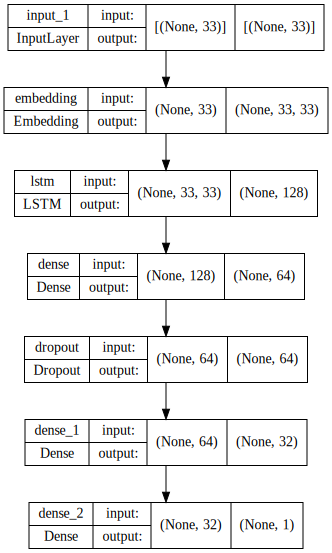

In [ ]:
COLAB = True
if COLAB:
    display(SVG(model_to_dot(models['anger'], show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(models['anger'], show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
models['anger'].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding (Embedding)       (None, 33, 33)            93984     
                                                                 
 lstm (LSTM)                 (None, 128)               82944     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33    

###Evaluate and Plot the results

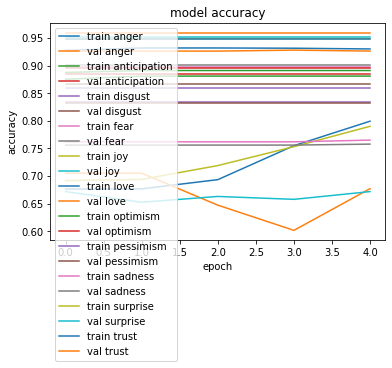

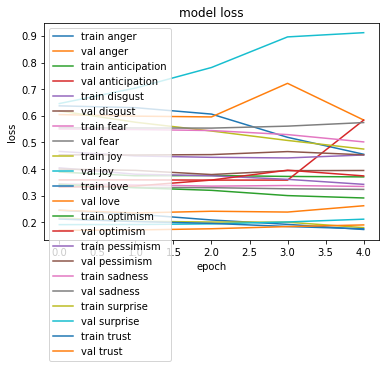

In [ ]:
import matplotlib.pyplot as plt

for i in history.keys():
  plt.plot(history[i].history['acc'],label='train %s' % i)
  plt.plot(history[i].history['val_acc'], label='val %s' % i)
  

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
plt.legend(loc='upper left')
plt.show()

for i in history.keys():
  plt.plot(history[i].history['loss'], label='train %s' % i)
  plt.plot(history[i].history['val_loss'],label='val %s' % i)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [ ]:
def evaluate_models(model):
    score = dict()

    for sent in Y_train.columns:

        # y_trains[sent] = Y_train[[sent]].astype(int).values
        y_tests = Y_test[[sent]].astype(int).values
        score[sent] = model.evaluate(X_test, y_tests, verbose=1)

    return score

In [ ]:
for i in models.keys():
  score = evaluate_models(models[i])
  print("Test Score " + str(i) + ":", score[i][0])
  print("Test Accuracy " + str(i) + ":", score[i][1])
  

23/23 [==============================] - 0s 4ms/step - loss: 0.5172 - acc: 0.7405
Test Score anger: 0.6432068347930908
Test Accuracy anger: 0.6465638279914856
23/23 [==============================] - 0s 4ms/step - loss: 0.2455 - acc: 0.9523
Test Score anticipation: 0.5712611079216003
Test Accuracy anticipation: 0.8906030654907227
23/23 [==============================] - 0s 4ms/step - loss: 0.2374 - acc: 0.9523
Test Score disgust: 0.4986392557621002
Test Accuracy disgust: 0.8260869383811951
23/23 [==============================] - 0s 4ms/step - loss: 0.2240 - acc: 0.9523
Test Score fear: 0.35756903886795044
Test Accuracy fear: 0.8849930167198181
23/23 [==============================] - 0s 4ms/step - loss: 0.3638 - acc: 0.8373
Test Score joy: 0.8098472952842712
Test Accuracy joy: 0.7124824523925781
23/23 [==============================] - 0s 4ms/step - loss: 0.2684 - acc: 0.9243
Test Score love: 0.3754405677318573
Test Accuracy love: 0.8990182280540466
23/23 [============================

## Test the models

Format the test dataset

In [ ]:
# Translate the words into their numerical values for test
all_words = []
embedded_sentences = []

for tweet in test_clean['tokenized_sents']:
  for word in tweet:
    all_words.append(word)

unique_words = set(all_words)
print(len(unique_words))

embedded_sentences_test = [one_hot(tweet, len(unique_words)) for tweet in test_clean['Tweet']]
print(embedded_sentences_test)

2623
[[1913, 1084, 1591, 1279, 1213, 2188, 688, 2595, 905, 1108], [1919, 861, 729, 391, 513, 193, 1141, 1160, 4, 489, 1084, 1373, 213, 1634, 1947, 391, 1439, 1295, 546, 1913, 1160, 1678], [954, 1141, 1913, 1084, 2121, 638, 5, 2050, 80, 2426, 980, 1013, 1020], [1405, 600, 1148, 1031, 1696, 1705, 2443, 431, 2392, 2314, 2381], [1081, 489, 688, 1858, 443, 2413, 391, 2447, 2553], [944, 770, 2212, 2134], [1439, 1970, 5, 1960, 489, 1858, 1971, 1355], [2441, 1482, 489, 1213, 2220, 1913, 2284, 1173, 1405, 5, 2407, 2137, 1591, 5, 1088, 489, 1786, 1637, 1352, 391, 1974, 1031, 976, 1497, 240, 2521], [2314, 693, 1180, 28, 513, 875, 1151], [1305, 2153, 80, 1006, 1213, 2136, 391, 1480, 1858, 2418, 1514], [1919, 1993, 2314, 1213, 1485, 1841, 2572, 660, 159, 1570, 489, 653, 2490, 503, 512, 1281, 2314, 1786, 537, 99], [1857, 727, 776, 688, 1008, 968, 2365, 1497, 1213, 1042, 391, 794, 166, 727, 875, 1084, 1649, 1423, 380], [391, 2057, 1280, 561, 2314, 1073, 1084, 903, 569, 467, 25, 2598, 2212, 2330, 1786

In [ ]:
# The sentences might have a different length. We want all of them of the same length
word_count = lambda sentence: len(nltk.word_tokenize(sentence))
longest_sentence = max(test_clean['Tweet'], key=word_count)
length_long_sentence = len(nltk.word_tokenize(longest_sentence))
print(length_long_sentence)

32


In [ ]:
padded_sentences_test = pad_sequences(embedded_sentences_test, 33, padding='post')
print(padded_sentences_test)

[[1913 1084 1591 ...    0    0    0]
 [1919  861  729 ...    0    0    0]
 [ 954 1141 1913 ...    0    0    0]
 ...
 [ 846 1413  391 ...    0    0    0]
 [ 924  513 1666 ...    0    0    0]
 [ 513 1028  367 ...    0    0    0]]


In [ ]:
np.shape(padded_sentences_test)

(679, 33)

In [ ]:
def predict_models(model, data):
  y_preds = model.predict(data, verbose=1)
  return y_preds

In [ ]:
# import copy
# results = pd.DataFrame(test[['Tweet']])


# y_preds = predict_models(models['anger'], padded_sentences_test)
# print(y_preds[0])

# y_preds2 = dict()
# y_preds2 = predict_models(models['trust'], padded_sentences_test)
# print(y_preds2[0])


# models = dict()
# # y_trains = dict()
# history = dict()

# for sent in Y_train.columns:
#     model = Model(inputs=input_1, outputs=output1)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
#     # y_trains[sent] = Y_train[[sent]].astype(int).values
#     y_trains = Y_train[[sent]].astype(int).values
#     print(sent)
#     history[sent] = model.fit(X_train, y_trains, epochs=5, verbose=0, validation_split = 0.2, shuffle = False)
#     models[sent] = copy.deepcopy(model)
#     #models[sent] = model
#     y_preds = predict_models(model, padded_sentences_test)
#     y_preds2 = predict_models(models['anger'], padded_sentences_test)
#     y_preds_1 = predict_models(models[sent], padded_sentences_test)
#     print(y_preds[0])
#     print(y_preds_1[0])
#     print(y_preds2[0])
#     results[sent] = y_preds


# # y_preds = dict()
# for sent in Y_train.columns:
#   results[sent] = predict_models(models[sent], padded_sentences_test)
#     # y_preds_1 = predict_models(models[sent], padded_sentences_test)
#     # print(results[sent][0])
#     #   print(y_preds_1[0])



# for i in models.keys():
#   print(i)
#   print('New iteration')
#   # y_preds = predict_models(models[i], padded_sentences_test)
#   # print(y_preds[0])
#   results[i] = predict_models(models[i], padded_sentences_test)

In [ ]:
# results = pd.DataFrame(test[['Tweet']])
# results['anger'] = models['anger'].predict(padded_sentences_test, verbose=1)
# results['trust'] = models['trust'].predict(padded_sentences_test, verbose=1)

# print(results['anger'][0])
# print(results['trust'][0])




# for sent in Y_train.columns:
#   results[sent] = models[sent].predict(padded_sentences_test, verbose=1)
#     # y_preds_1 = predict_models(models[sent], padded_sentences_test)
#   print(results[sent][0])

In [ ]:
results = pd.DataFrame(test[['Tweet']])

for i in models.keys():
  results[i] = predict_models(models[i], padded_sentences_test)

22/22 [==============================] - 0s 3ms/step


In [ ]:
results

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,no me pienso perder la pelea de mcgregor contr...,0.574464,0.004359,0.183212,0.122804,0.017944,0.002399,0.005455,0.175846,0.304241,0.016909,0.001262
1,yo preocupada pensando que mi papa ya habia ll...,0.166749,0.004584,0.029463,0.126262,0.778818,0.492765,0.184113,0.183080,0.481178,0.145272,0.047869
2,pucha ya no me sirven todos los carros a rondi...,0.667632,0.004339,0.120794,0.121356,0.026411,0.002675,0.004604,0.175599,0.106711,0.012954,0.018682
3,si estar contigo es un delito hago cien anos e...,0.354895,0.004583,0.048651,0.122274,0.018513,0.002354,0.005459,0.175571,0.268617,0.005050,0.194943
4,perfect y de una mansa ni que terrible plr,0.082222,0.008308,0.036996,0.122683,0.029699,0.003064,0.005790,0.173293,0.113802,0.032455,0.001248
...,...,...,...,...,...,...,...,...,...,...,...,...
674,peligro al volante tec los santos memes gall...,0.630387,0.004337,0.111139,0.121921,0.019949,0.002351,0.004945,0.175104,0.190420,0.006509,0.001718
675,vamos a ver q sucedio en mi barrio en los 90 v...,0.808168,0.004172,0.230781,0.123524,0.016788,0.002444,0.005502,0.177543,0.518497,0.007041,0.157783
676,felicidades fer que esta pasando al agus par...,0.236309,0.004467,0.062508,0.122215,0.471015,0.100102,0.156753,0.174398,0.222116,0.178218,0.042206
677,lamento mi confusion de rama legislativa hab...,0.132404,0.005815,0.049819,0.118154,0.032356,0.001981,0.004648,0.183165,0.101685,0.007656,0.002481


In [ ]:
#export DataFrame to CSV file
results.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Datasets/NLP/test_results.csv', index=False)